In [1]:
# Importing the libraries
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from patchify import patchify, unpatchify
import keras.backend as K
import numpy as np

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Function to load the images
def loader(mask_dir):
    masks = []  # Initializing an empty list to store images

    # Looping through the images in the image directory
    for image_filename in os.listdir(mask_dir):
        if image_filename.endswith(".tif"):
            mask_path = os.path.join(mask_dir, image_filename)
            mask = cv2.imread(mask_path)
            masks.append(mask)
            
    return masks

In [3]:
# Setting the parameters
min_area_threshold = 50
top_position_threshold_bottom = 1300
top_position_threshold_top = 350
thin_line_threshold = 100
long_line_threshold = 200

In [4]:
# Creating f1 and iou metrics
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
model = keras.models.load_model('C:/Users/daraz/Desktop/BUas/Year 2 Block B/modelV9.h5', custom_objects={'f1': f1, 'iou': iou})

In [6]:
scaling_factor = 1
patch_size = 256

4/4 [==============================] - 9s 567ms/step


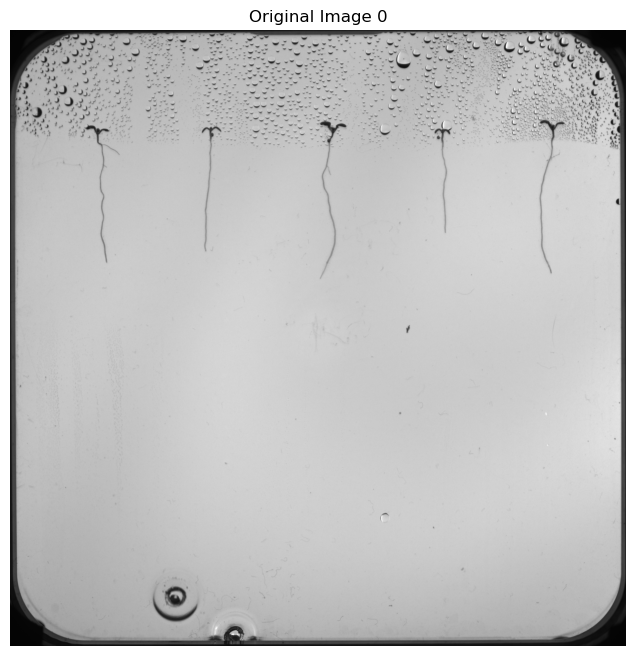

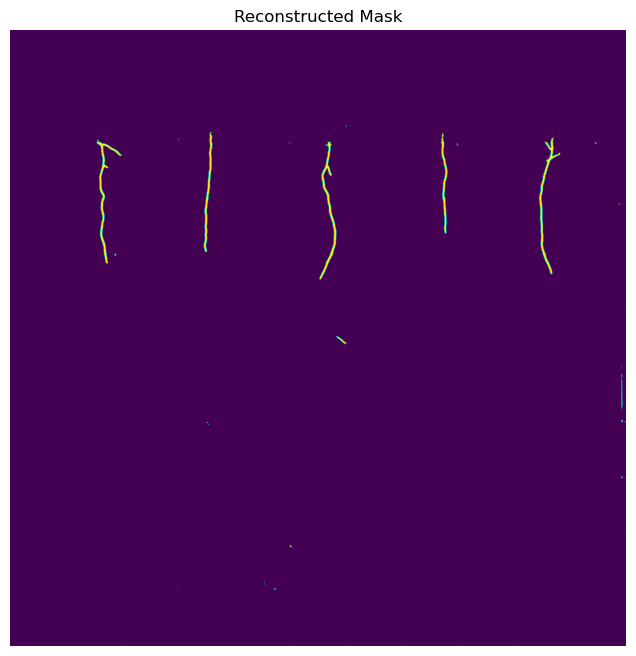

4/4 [==============================] - 0s 76ms/step


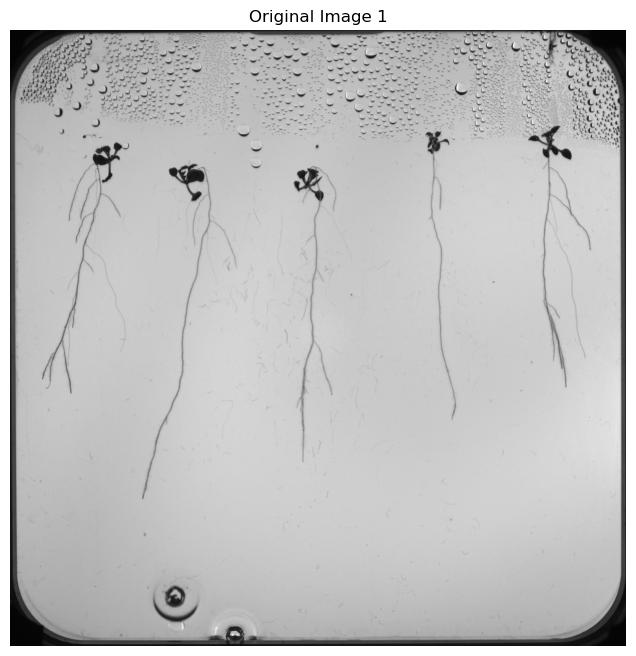

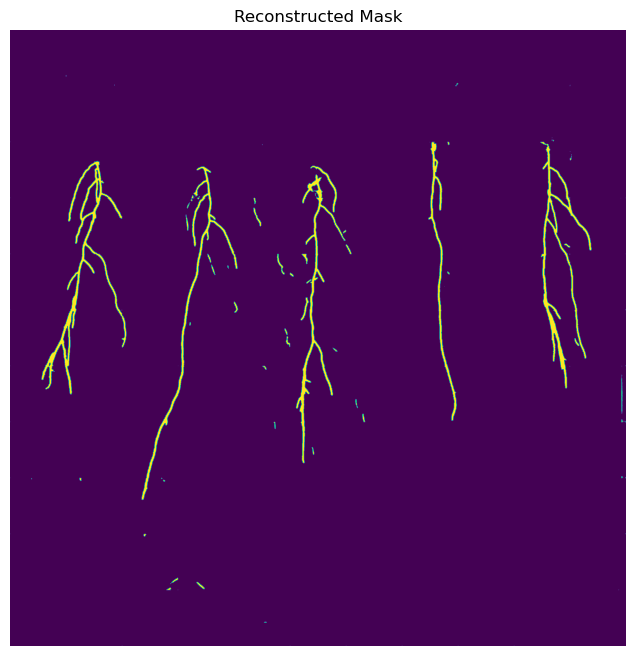

4/4 [==============================] - 0s 75ms/step


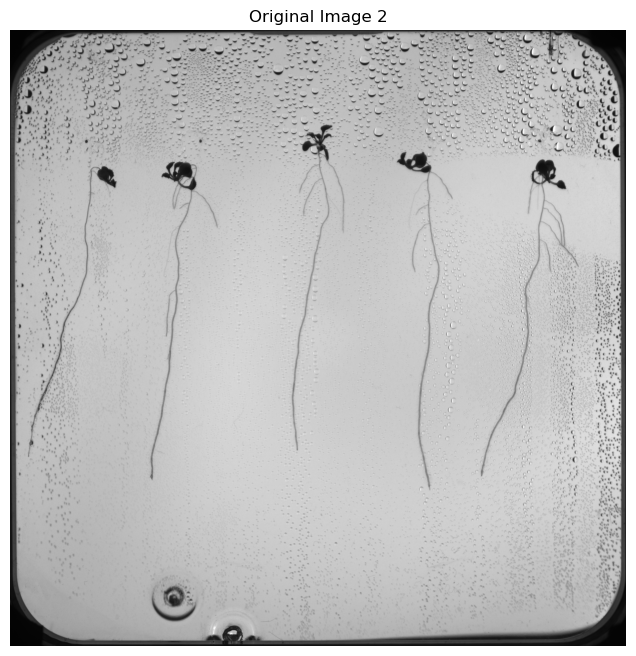

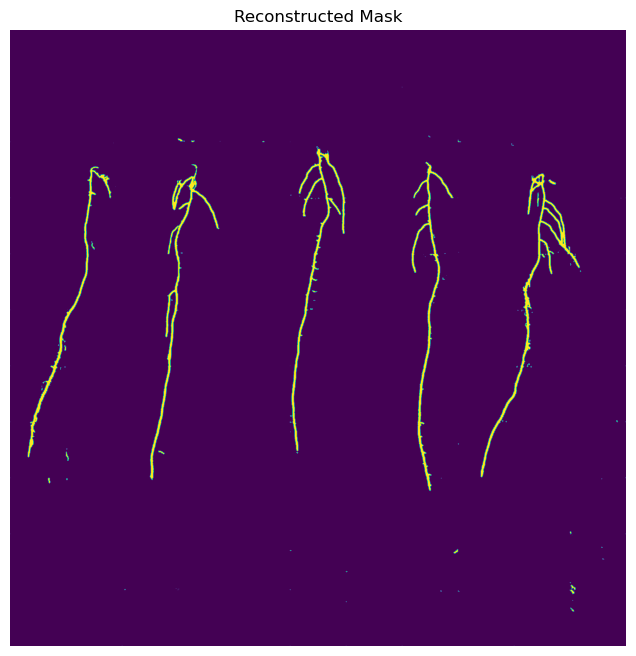

4/4 [==============================] - 0s 76ms/step


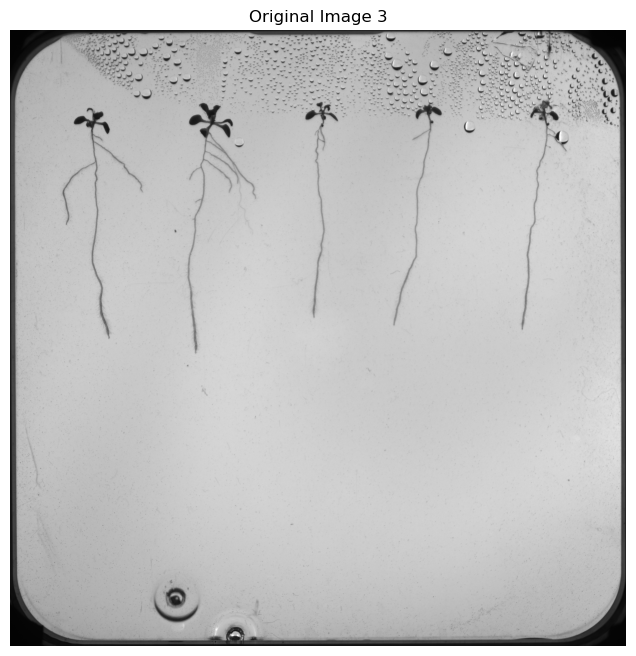

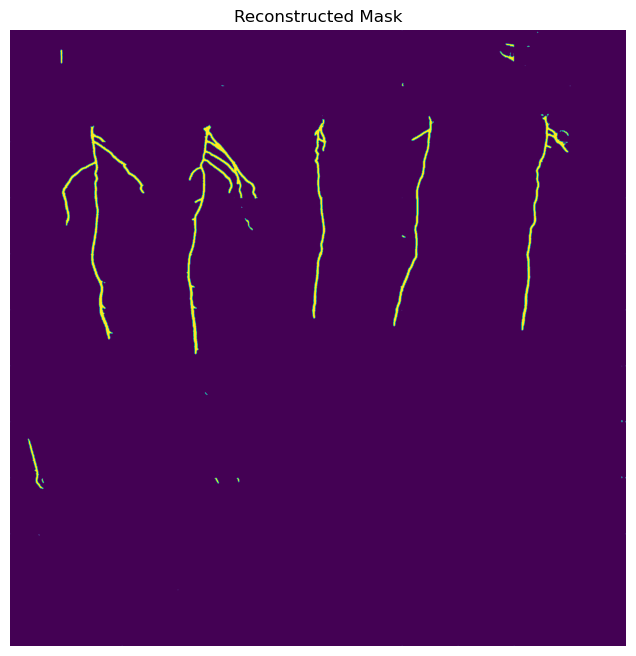

4/4 [==============================] - 0s 76ms/step


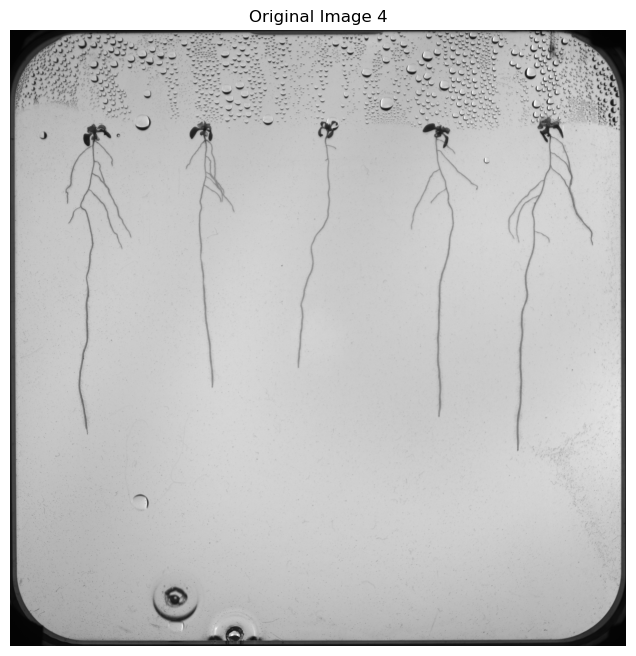

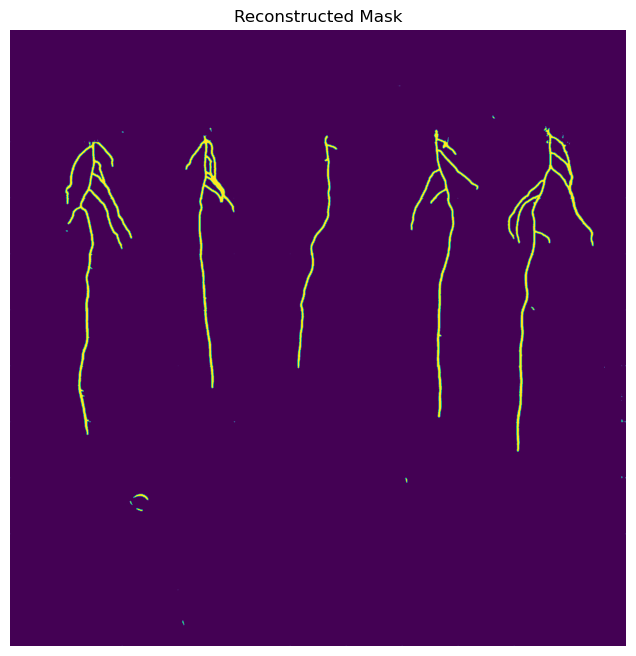

4/4 [==============================] - 0s 76ms/step


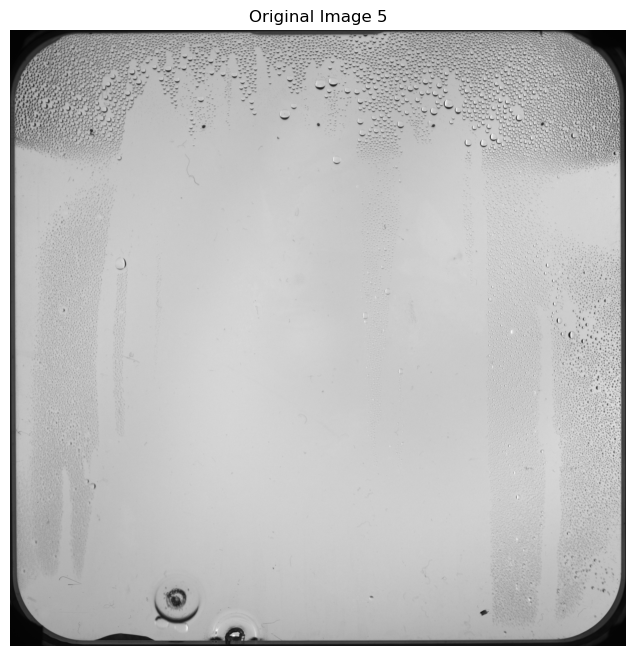

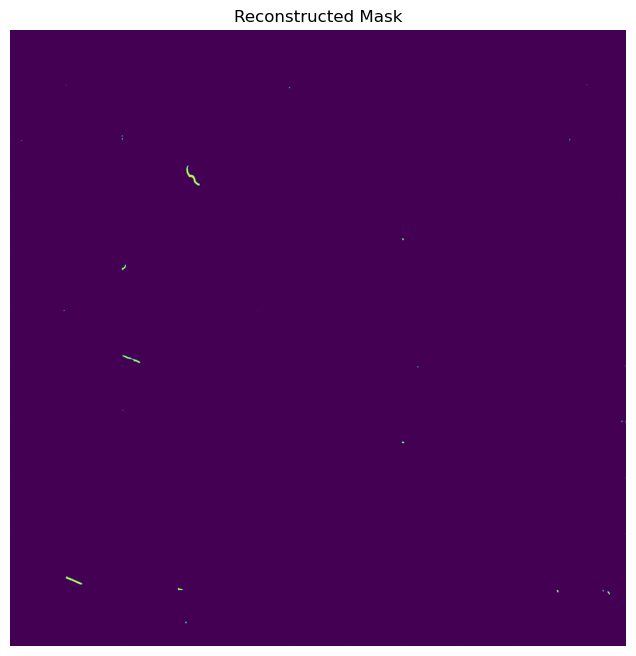

4/4 [==============================] - 0s 74ms/step


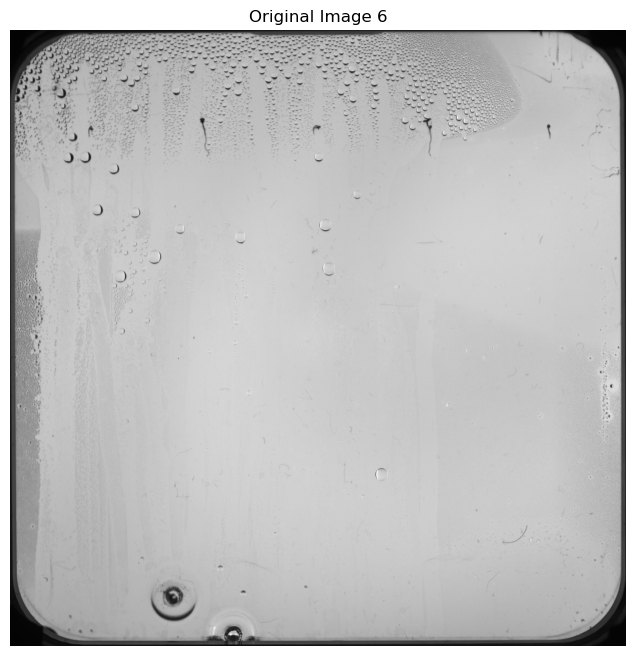

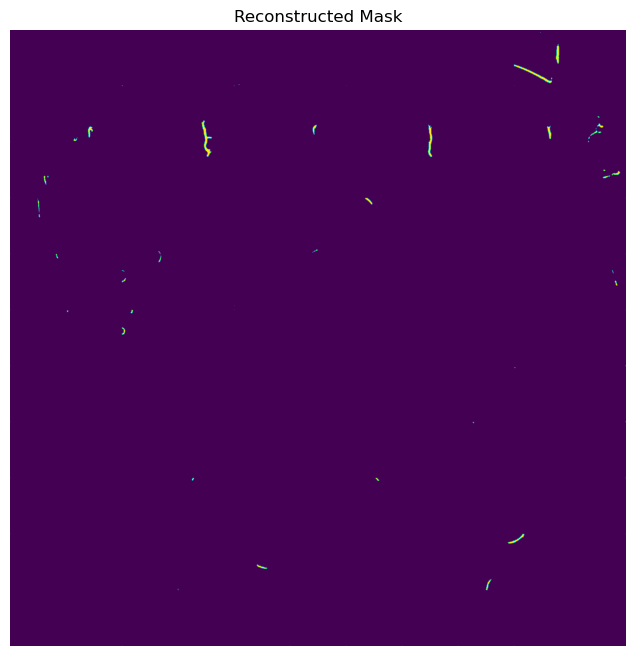

4/4 [==============================] - 0s 74ms/step


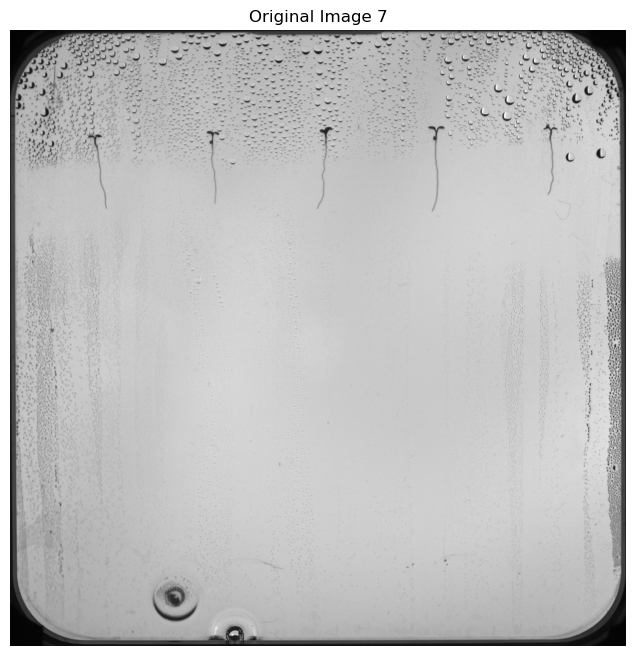

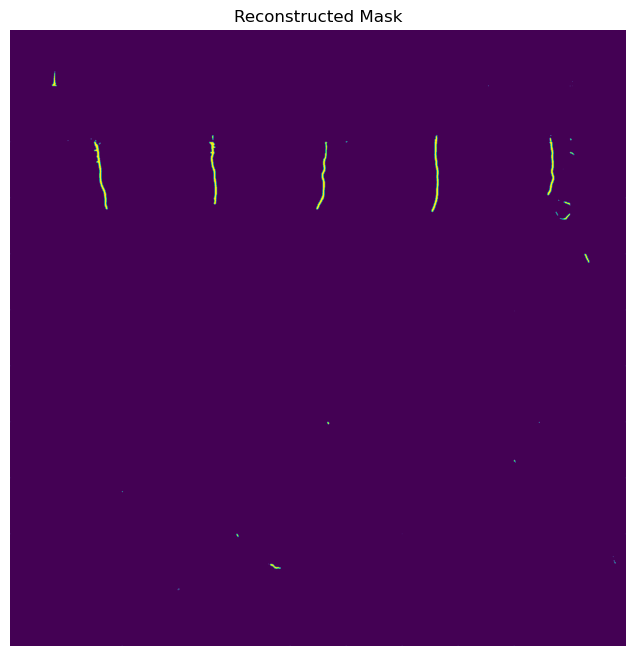

4/4 [==============================] - 0s 78ms/step


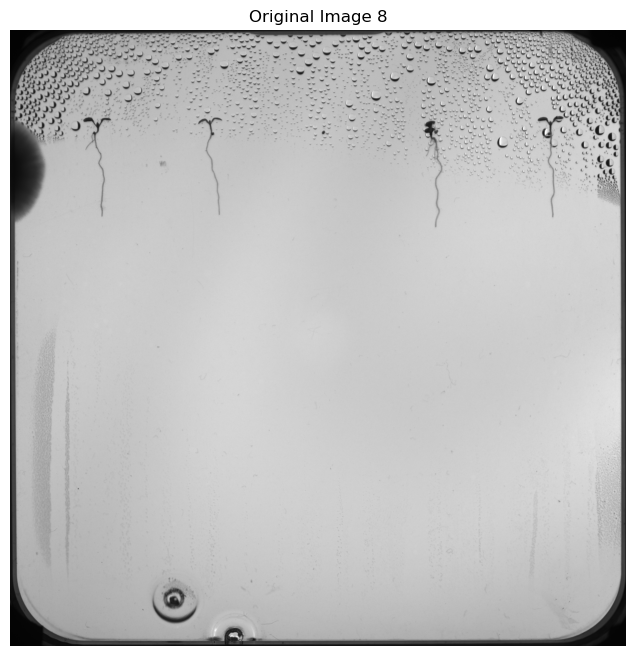

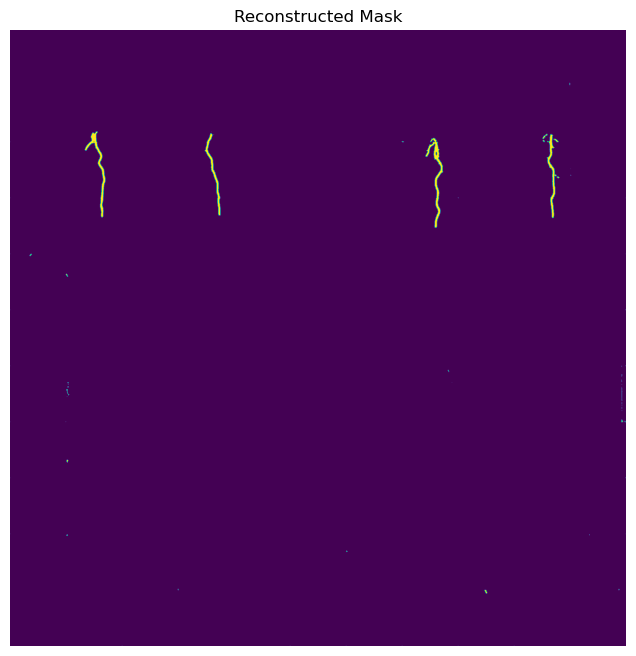

4/4 [==============================] - 0s 75ms/step


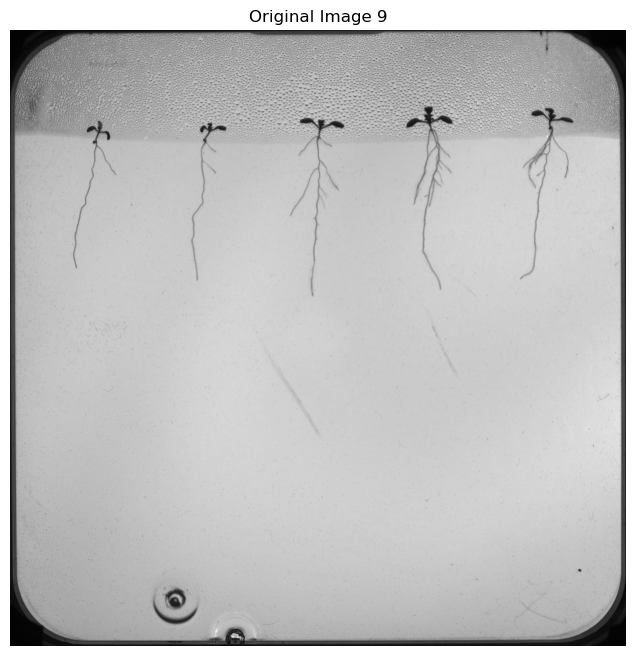

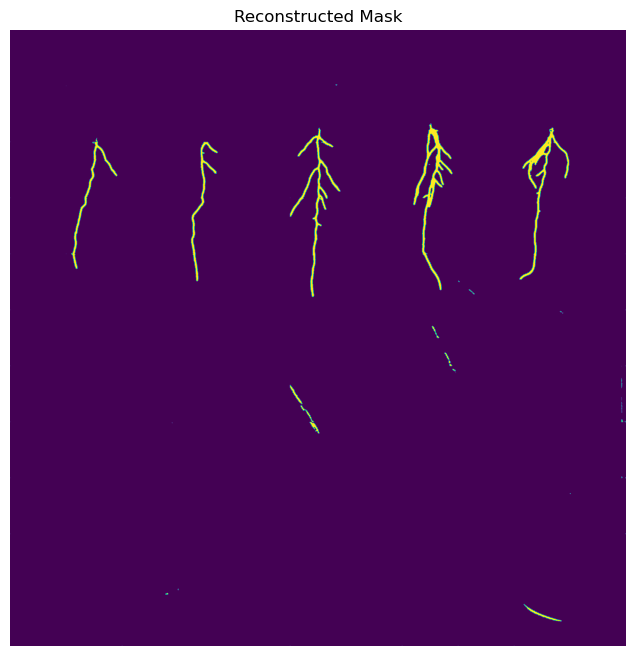

4/4 [==============================] - 0s 75ms/step


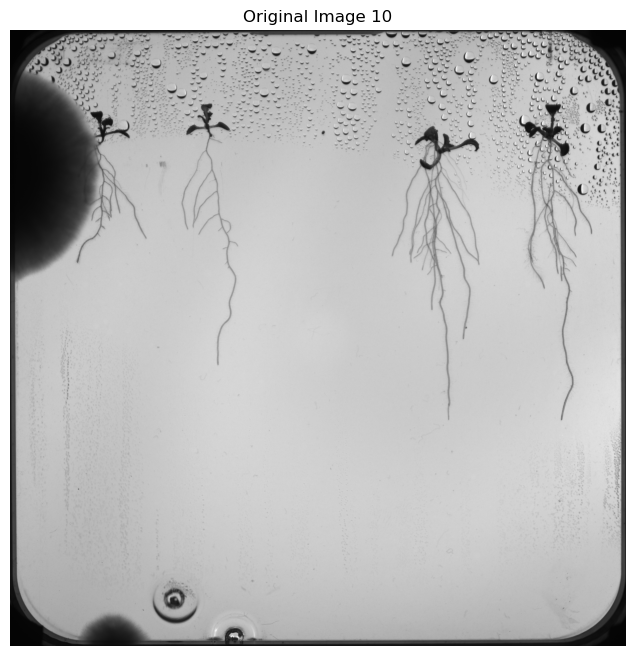

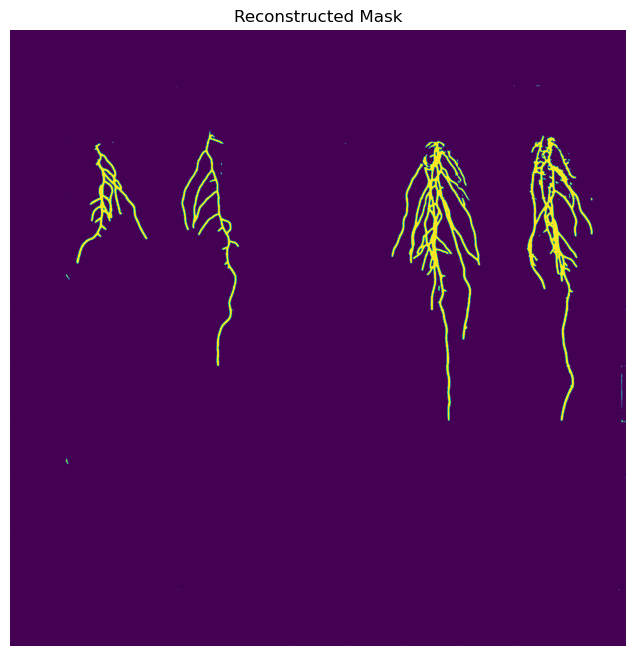

In [7]:
# Setting the image directory
image_dir = r'C:\Users\daraz\Desktop\BUas\Year 2 Block B\Kaggle data\cropped'

# Creating a list for storing the patches, predicted masks, images and reconstructed masks
patches_list = []
predicted_masks = []
images = []
reconstructed_masks = []

# Looping through the images in the image directory
for image_filename in os.listdir(image_dir):
    if image_filename.endswith(".png"):
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        images.append(image)

        # Calculating new dimensions after scaling
        new_height = int(image.shape[0] * scaling_factor)
        new_width = int(image.shape[1] * scaling_factor)

        # Ensuring the new dimensions are divisible by the patch size
        if new_height % patch_size != 0:
            new_height += patch_size - (new_height % patch_size)
        if new_width % patch_size != 0:
            new_width += patch_size - (new_width % patch_size)

        # Resizing image
        resized_image = cv2.resize(image, (new_width, new_height))

        # Creating patches
        patches = patchify(resized_image, (patch_size, patch_size, 3), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 3)
        patches_list.append(patches)

# Predicting and reconstructing masks
for i, patches in enumerate(patches_list):
    predicted_masks_batch = model.predict(patches/255)
    reshaped_masks_array = predicted_masks_batch.reshape(-1, patch_size, patch_size, 1)

    # Calculating grid size
    grid_size = int(np.sqrt(len(reshaped_masks_array)))

    # Unpatchifying the masks
    reshaped_masks_array = reshaped_masks_array.reshape(grid_size, grid_size, patch_size, patch_size)
    reconstructed_mask = unpatchify(reshaped_masks_array, (new_height, new_width))
    reconstructed_mask = reconstructed_mask > 0.05
    reconstructed_masks.append(reconstructed_mask)

    # Displaying the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(images[i])
    plt.title(f"Original Image {i}")
    plt.axis('off')
    plt.show()

    # Displaying each reconstructed mask
    plt.figure(figsize=(8, 8))
    plt.imshow(reconstructed_mask, cmap='viridis')
    plt.title("Reconstructed Mask")
    plt.axis('off')
    plt.show()    

Number of components detected: 60


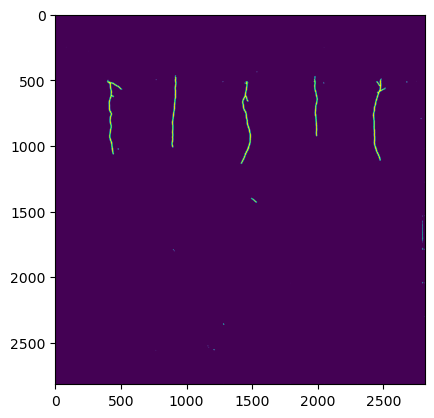

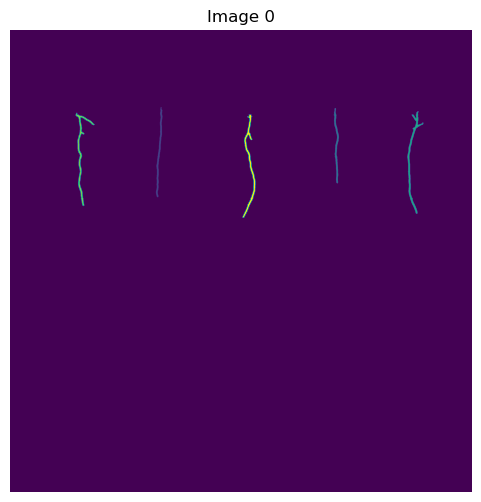

[[      0       0    2816    2816 7898146]
 [    890     470      39     549    5469]
 [   1973     476      31     458    4406]
 [   2422     495      97     625    7296]
 [    400     504     115     568    7111]
 [   1418     516      78     628    7428]]
Number of components detected: 120


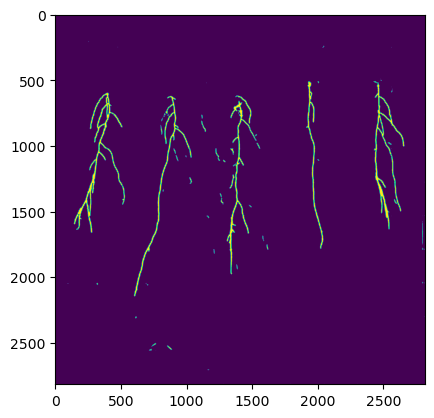

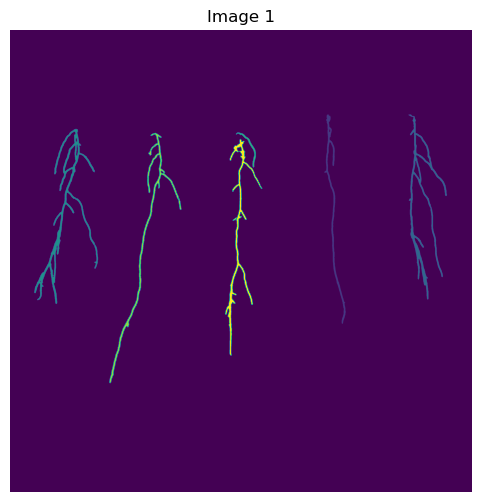

[[      0       0    2816    2816 7798780]
 [   1916     516     130    1274   15483]
 [   2429     516     234    1126   29720]
 [    148     603     388    1066   35646]
 [   1377     625     121     212    2463]
 [    606     628     438    1524   23637]
 [   1312     664     225    1320   24127]]
Number of components detected: 153


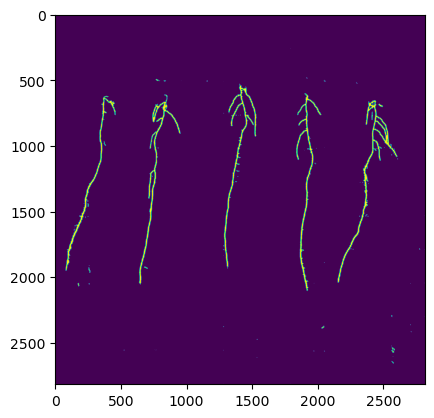

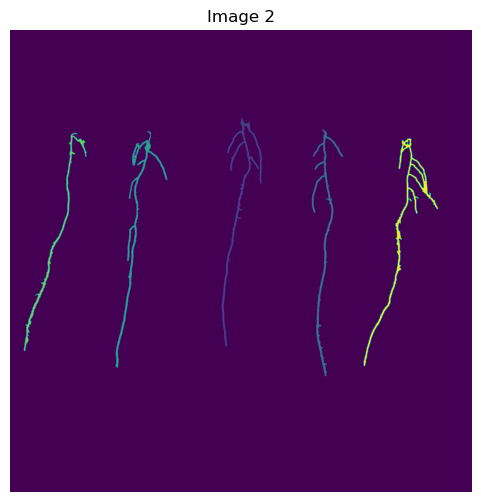

[[      0       0    2816    2816 7807084]
 [   1291     536     247    1393   24741]
 [   1840     607     192    1504   23368]
 [    644     618     316    1443   25795]
 [     85     628     381    1329   18941]
 [   2156     660     453    1388   29927]]
Number of components detected: 59


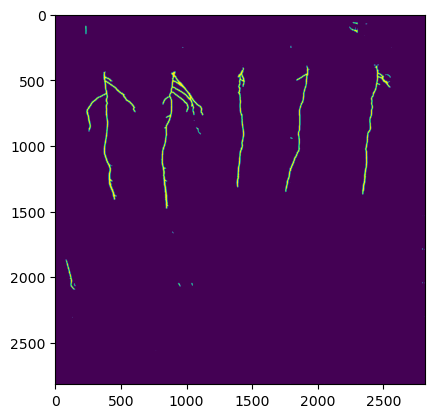

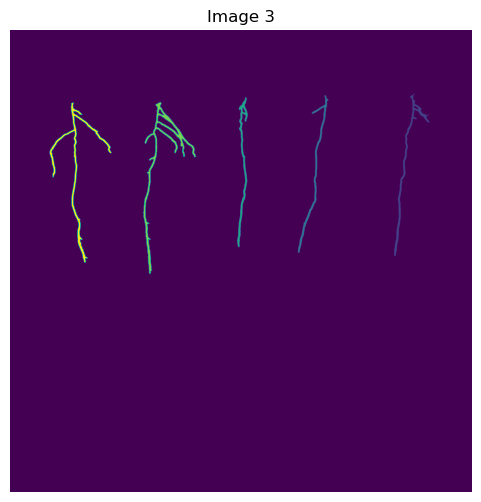

[[      0       0    2816    2816 7846923]
 [   2341     388     216     989   13667]
 [   1756     397     184     961   11555]
 [   1385     411      66     912   11831]
 [    812     438     324    1048   25144]
 [    242     441     376     977   20736]]
Number of components detected: 70


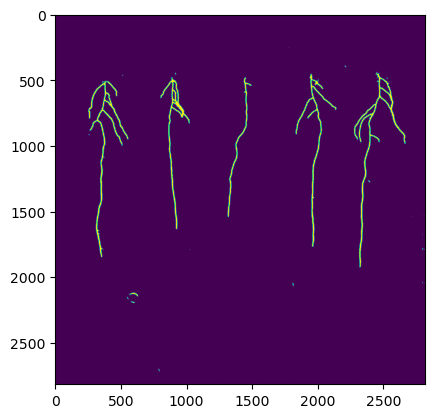

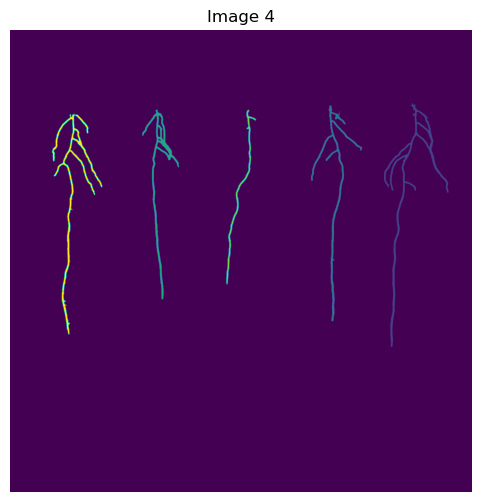

[[      0       0    2816    2816 7808972]
 [   2280     444     392    1488   33236]
 [   1835     460     311    1315   23250]
 [    805     486     225    1155   22205]
 [   1318     486     182    1064   11914]
 [    256     510     306    1345   30279]]
Number of components detected: 51


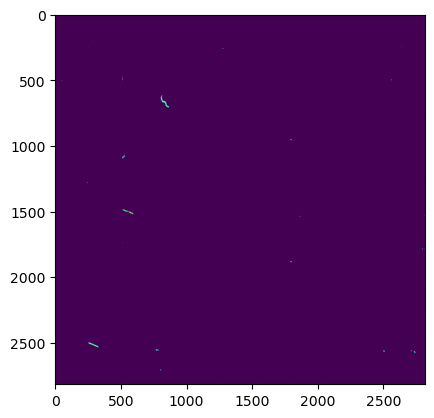

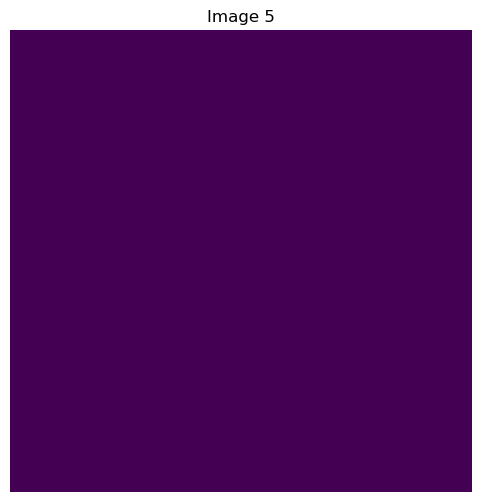

[[      0       0    2816    2816 7929856]]
Number of components detected: 85


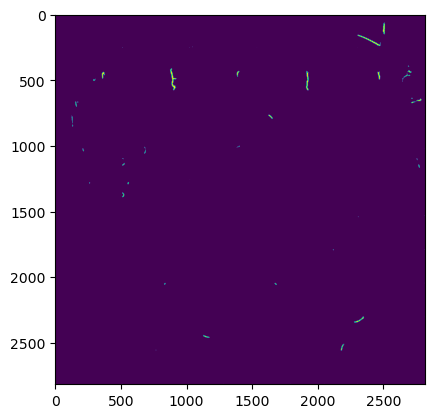

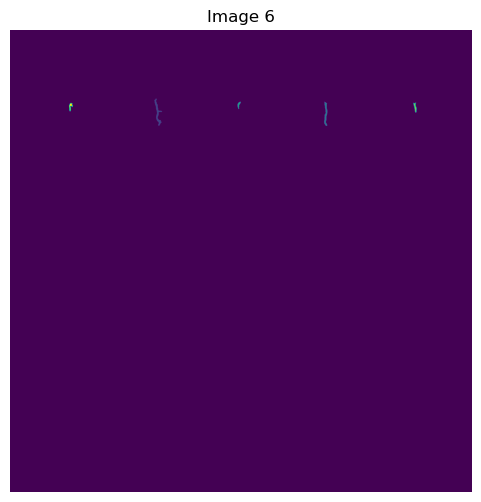

[[      0       0    2816    2816 7924846]
 [    880     417      47     167    2057]
 [   1915     437      19     147    1468]
 [   1388     438      18      44     348]
 [   2459     442      19      60     590]
 [    361     445      22      50     547]]
Number of components detected: 65


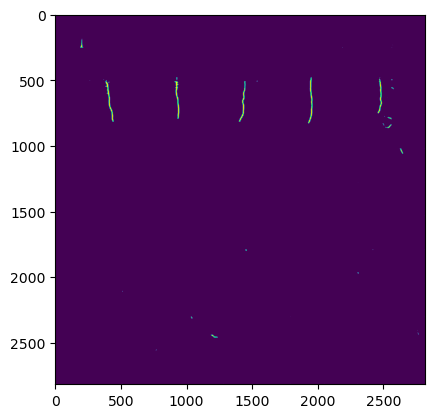

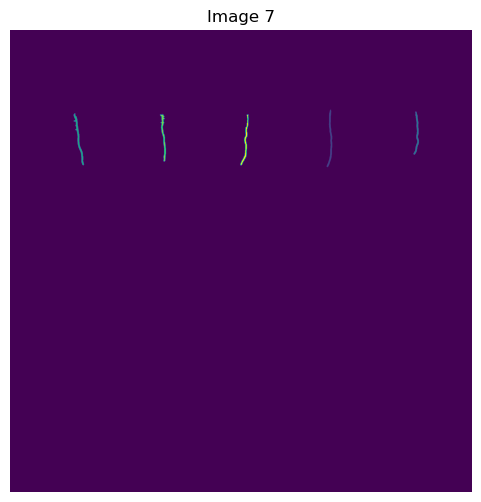

[[      0       0    2816    2816 7914516]
 [   1930     484      34     352    3461]
 [   2460     497      32     262    2533]
 [    388     507      63     317    3357]
 [    914     511      36     290    3088]
 [   1404     516      50     308    2901]]
Number of components detected: 86


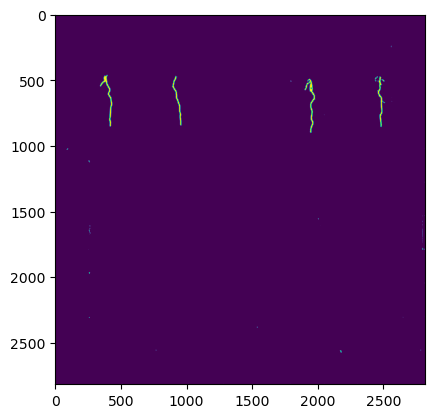

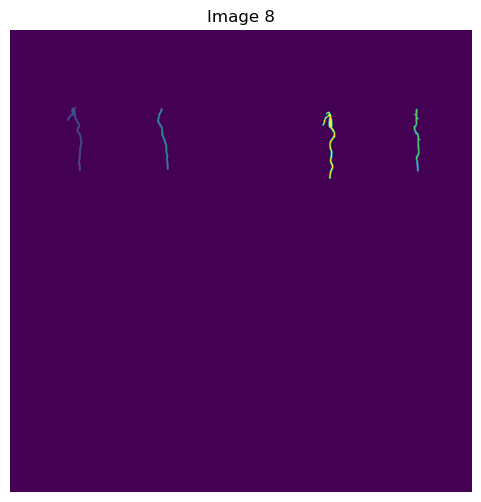

[[      0       0    2816    2816 7910277]
 [    346     468      94     392    5279]
 [    895     476      71     376    3980]
 [   2459     479      43     384    4255]
 [   1904     498      80     410    6065]]
Number of components detected: 68


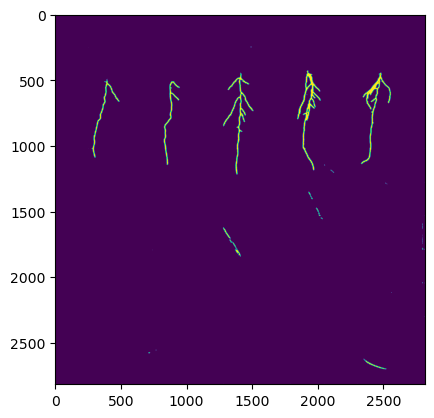

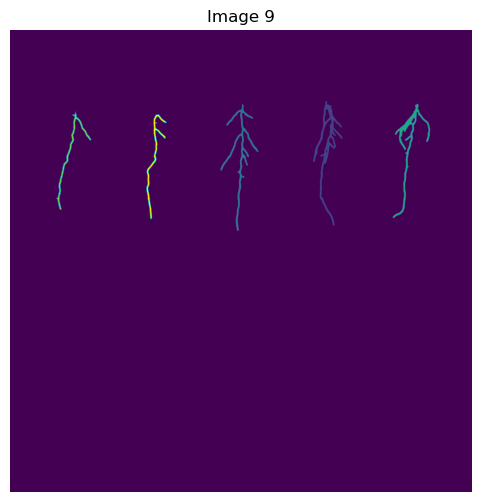

[[      0       0    2816    2816 7861952]
 [   1847     432     180     761   19606]
 [   1284     450     230     774   16129]
 [   2333     450     227     695   15880]
 [    284     497     210     599    7960]
 [    832     516     122     636    8329]]
Number of components detected: 94


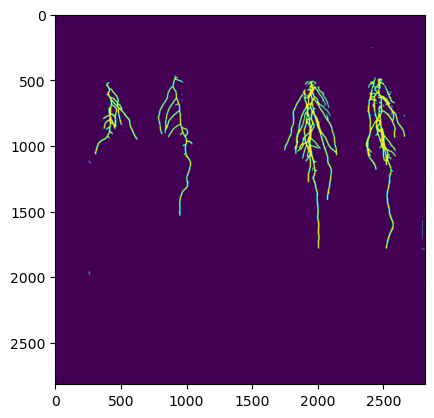

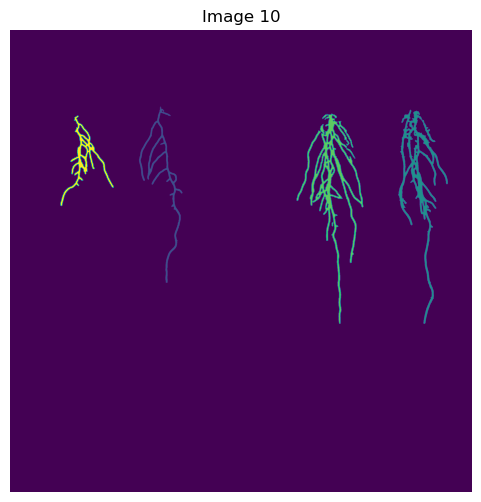

[[      0       0    2816    2816 7758421]
 [    787     464     264    1076   23917]
 [   2367     487     301    1304   55182]
 [   1748     511     405    1279   70890]
 [    306     522     326     550   21446]]


In [8]:
output_dir = r'C:\Users\daraz\Desktop\BUas\Year 2 Block B\Kaggle data\task5'

filtereds = []

for index, mask in enumerate(reconstructed_masks):
    mask = mask.astype(np.uint8)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    print(f"Number of components detected: {retval - 1}")

    plt.imshow(reconstructed_masks[index], cmap='viridis')
    plt.show()

    # Initializing a mask to keep the relevant components
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)

    # Iterating through the connected components
    for component_index in range(1, retval):
        area = stats[component_index, cv2.CC_STAT_AREA]
        top = stats[component_index, cv2.CC_STAT_TOP]
        left = stats[component_index, cv2.CC_STAT_LEFT]
        width = stats[component_index, cv2.CC_STAT_WIDTH]
        height = stats[component_index, cv2.CC_STAT_HEIGHT]

        # Checking if the component is wider than the thin line threshold
        is_wide = width > thin_line_threshold
        extends_beyond_top_zone = top + height > 500
        within_top_boundary = 360 <= top <= 560

        # Checking if the component meets the criteria IMAGE 64 IS STILL NOT PERFECT
        #           50                                        400                      1500                
        if (min_area_threshold <= area) and top_position_threshold_top < top < top_position_threshold_bottom \
            and (2500 > left > 15) or within_top_boundary:
            # If it does, adding it to the mask
            filtered_mask[labels == component_index] = 255

    # Applying a dilation to the mask
    kernel = np.ones((2, 2), np.uint8)

    filtered_mask = cv2.dilate(filtered_mask, kernel, iterations=4)
    filtered_mask = cv2.erode(filtered_mask, kernel, iterations=4)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask)

    filtered_mask_2 = np.zeros_like(filtered_mask, dtype=np.uint8)

    # Iterating through the connected components
    for component_index in range(1, retval):
        area = stats[component_index, cv2.CC_STAT_AREA]
        top = stats[component_index, cv2.CC_STAT_TOP]

        within_top_boundary = 400 <= top <= 500

        # Checking if the component meets the criteria
        if 1500 < area or within_top_boundary and top < top_position_threshold_bottom:
            # If it does, adding it to the mask
            filtered_mask_2[labels == component_index] = 255

    filtered_mask_2[:200, :] = np.zeros((200, filtered_mask_2.shape[1]), dtype=np.uint8)
    filtered_mask_2[:, -30:] = np.zeros((filtered_mask_2.shape[0], 30), dtype=np.uint8)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask_2)

    filtered_mask_3 = np.zeros_like(filtered_mask_2, dtype=np.uint8)

    for component_index in range(1, retval):
        area = stats[component_index, cv2.CC_STAT_AREA]

        # Checking if the component meets the criteria
        if 280 < area:
            # If it does, adding it to the mask
            filtered_mask_3[labels == component_index] = 255

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask_3)

    filename = os.path.join(output_dir, f"mask_{index}.png")
    cv2.imwrite(filename, filtered_mask_3.astype(np.uint8))

    filtereds.append(filtered_mask_3)

    plt.figure(figsize=(6, 6))
    plt.imshow(labels, cmap='viridis')
    plt.title(f"Image {index}")
    plt.axis('off')
    plt.show()

    print(stats)

[[      0       0     650    2816 1823289]
 [    400     504     115     568    7111]]


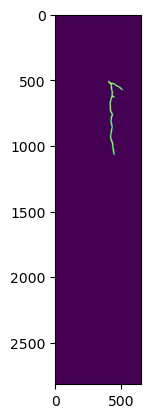

[[      0       0     620    2816 1740451]
 [    310     470      39     549    5469]]


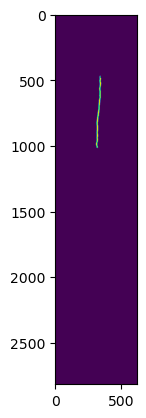

[[      0       0     600    2816 1682172]
 [    218     516      78     628    7428]]


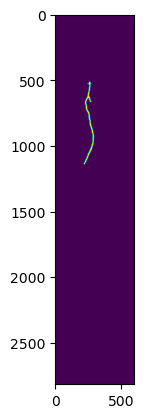

[[      0       0     600    2816 1685194]
 [    273     476      31     458    4406]]


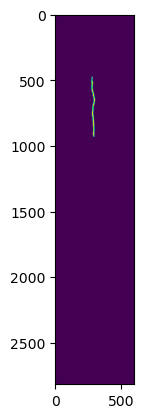

[[      0       0     700    2816 1963904]
 [    322     495      97     625    7296]]


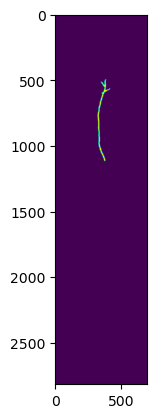

[[      0       0     650    2816 1792747]
 [    148     603     388    1066   35646]
 [    606    1966      44     186    2007]]


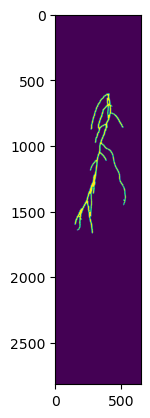

[[      0       0     620    2816 1722283]
 [     26     628     438    1524   23637]]


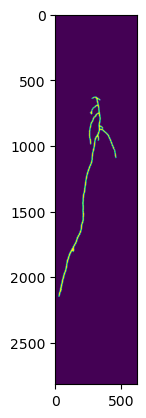

[[      0       0     600    2816 1663010]
 [    177     625     121     212    2463]
 [    112     664     225    1320   24127]]


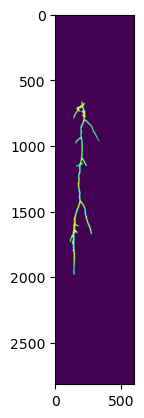

[[      0       0     600    2816 1674117]
 [    216     516     130    1274   15483]]


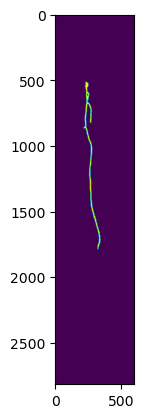

[[      0       0     700    2816 1941480]
 [    329     516     234    1126   29720]]


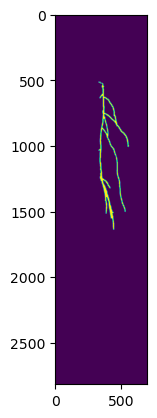

[[      0       0     650    2816 1811066]
 [     85     628     381    1329   18941]
 [    644    1937       6     118     393]]


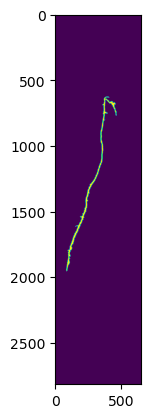

[[      0       0     620    2816 1720125]
 [     64     618     316    1443   25795]]


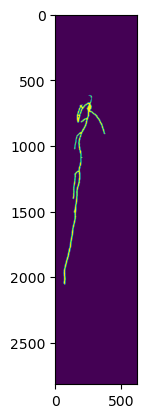

[[      0       0     600    2816 1664859]
 [     91     536     247    1393   24741]]


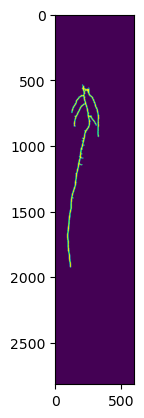

[[      0       0     600    2816 1661699]
 [    140     607     192    1504   23368]
 [    456    1675     144     373    4533]]


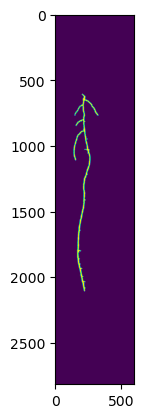

[[      0       0     700    2816 1941273]
 [     56     660     453    1388   29927]]


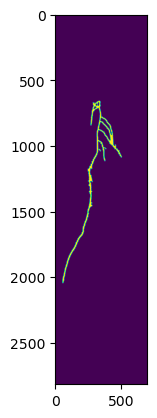

[[      0       0     650    2816 1809664]
 [    242     441     376     977   20736]]


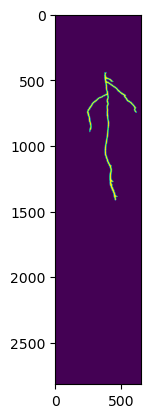

[[      0       0     620    2816 1719879]
 [    232     438     324    1048   25144]
 [      0     673      38      78     897]]


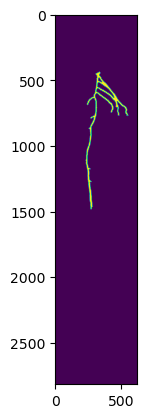

[[      0       0     600    2816 1675634]
 [    185     411      66     912   11831]
 [    556    1163      44     195    2135]]


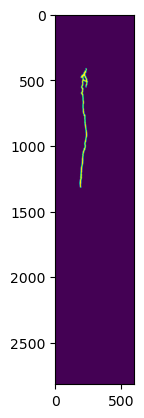

[[      0       0     600    2816 1678045]
 [     56     397     184     961   11555]]


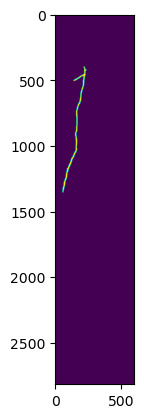

[[      0       0     700    2816 1957533]
 [    241     388     216     989   13667]]


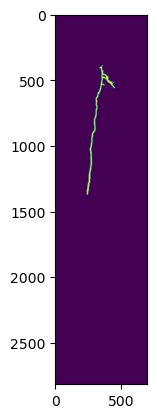

[[      0       0     650    2816 1800121]
 [    256     510     306    1345   30279]]


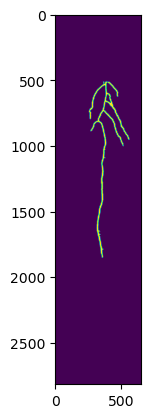

[[      0       0     620    2816 1723715]
 [    225     486     225    1155   22205]]


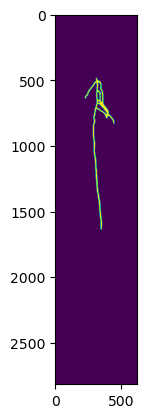

[[      0       0     600    2816 1677686]
 [    118     486     182    1064   11914]]


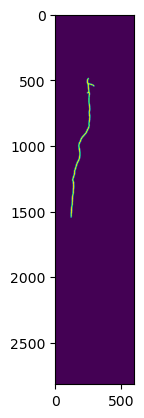

[[      0       0     600    2816 1665352]
 [    135     460     311    1315   23250]
 [    580     838      20     111     998]]


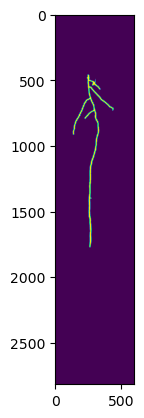

[[      0       0     700    2816 1937321]
 [    180     444     392    1488   33236]
 [      0     682      46      53     643]]


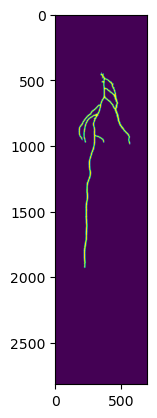

[[      0       0     650    2816 1830400]]


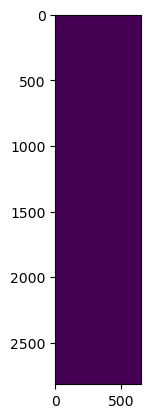

[[      0       0     620    2816 1745920]]


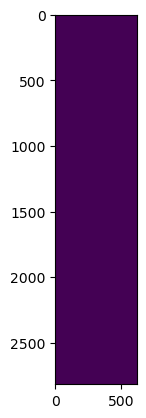

[[      0       0     600    2816 1689600]]


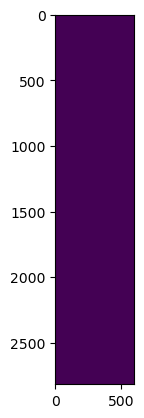

[[      0       0     600    2816 1689600]]


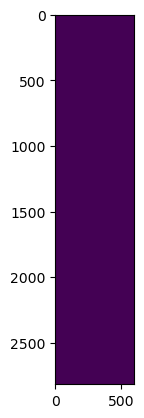

[[      0       0     700    2816 1971200]]


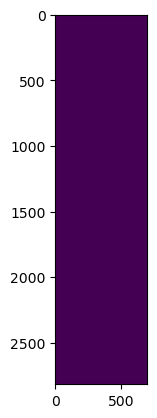

[[      0       0     650    2816 1829853]
 [    361     445      22      50     547]]


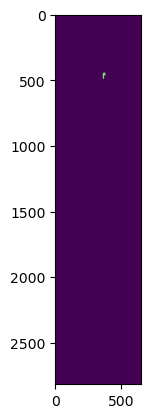

[[      0       0     620    2816 1743863]
 [    300     417      47     167    2057]]


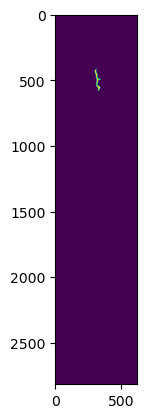

[[      0       0     600    2816 1689252]
 [    188     438      18      44     348]]


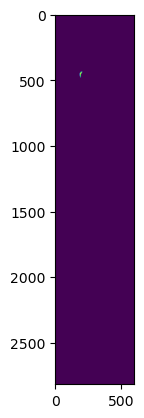

[[      0       0     600    2816 1688132]
 [    215     437      19     147    1468]]


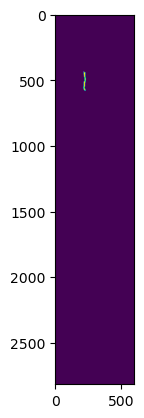

[[      0       0     700    2816 1970610]
 [    359     442      19      60     590]]


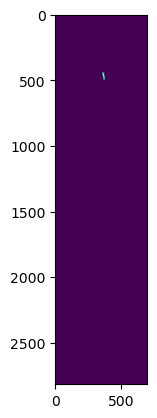

[[      0       0     650    2816 1827043]
 [    388     507      63     317    3357]]


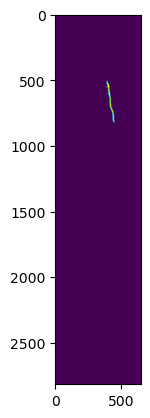

[[      0       0     620    2816 1742832]
 [    334     511      36     290    3088]]


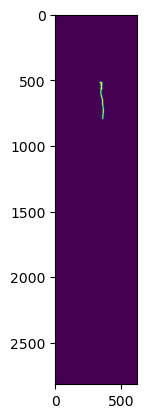

[[      0       0     600    2816 1686699]
 [    204     516      50     308    2901]]


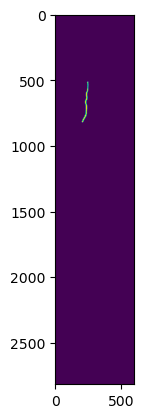

[[      0       0     600    2816 1686139]
 [    230     484      34     352    3461]]


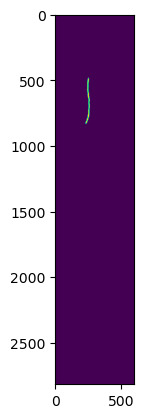

[[      0       0     700    2816 1968667]
 [    360     497      32     262    2533]]


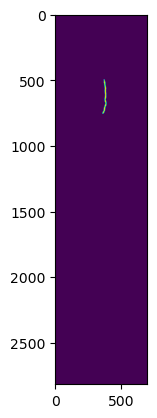

[[      0       0     650    2816 1825121]
 [    346     468      94     392    5279]]


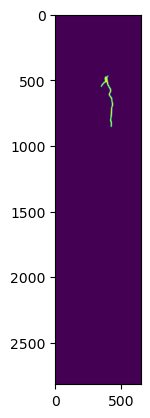

[[      0       0     620    2816 1741940]
 [    315     476      71     376    3980]]


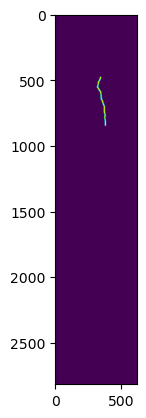

[[      0       0     600    2816 1689600]]


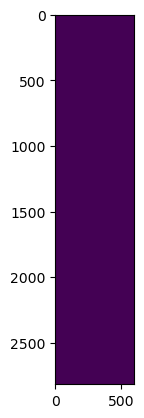

[[      0       0     600    2816 1683535]
 [    204     498      80     410    6065]]


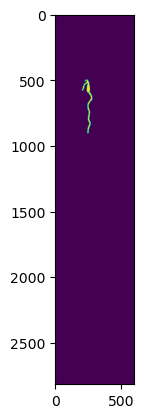

[[      0       0     700    2816 1966945]
 [    359     479      43     384    4255]]


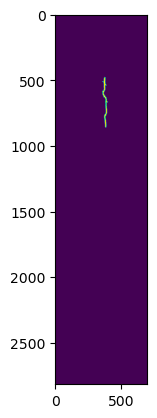

[[      0       0     650    2816 1822440]
 [    284     497     210     599    7960]]


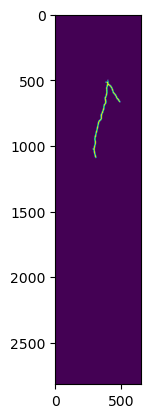

[[      0       0     620    2816 1737591]
 [    252     516     122     636    8329]]


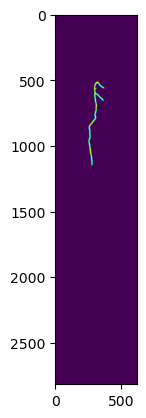

[[      0       0     600    2816 1673471]
 [     84     450     230     774   16129]]


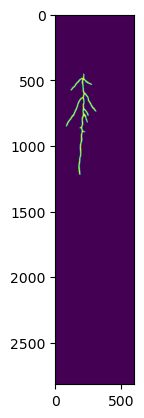

[[      0       0     600    2816 1669994]
 [    147     432     180     761   19606]]


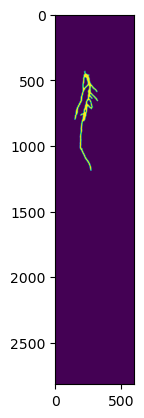

[[      0       0     700    2816 1955320]
 [    233     450     227     695   15880]]


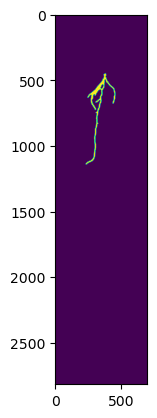

[[      0       0     650    2816 1808954]
 [    306     522     326     550   21446]]


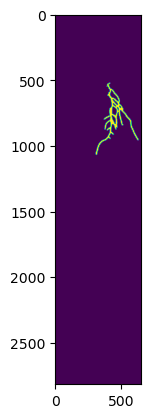

[[      0       0     620    2816 1720827]
 [    207     464     264    1076   23917]
 [      0     849      52     112    1176]]


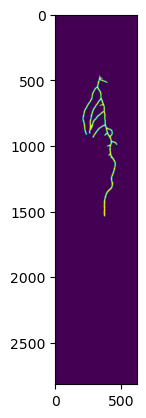

[[      0       0     600    2816 1688157]
 [    548     871      52     170    1443]]


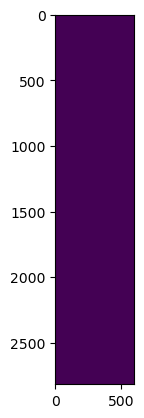

[[      0       0     600    2816 1618710]
 [     48     511     405    1279   70890]]


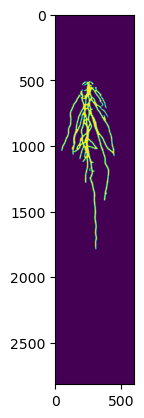

[[      0       0     700    2816 1912048]
 [    267     487     301    1304   55182]
 [      0     776       4       7      21]
 [      0     835      53     245    2945]
 [      0    1159      12     140    1004]]


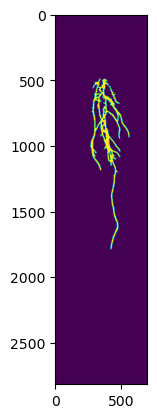

In [9]:
# Creating a list to store the mask slices in
sliced_masks = []

# Looping through the filtered masks and slicing them
for mask in filtereds:
    slices = [
        mask[:, :650],
        mask[:, 580:1200],
        mask[:, 1200:1800],
        mask[:, 1700:2300],
        mask[:, 2100:2800]
    ]
    
    # Appending the slices to the list
    sliced_masks.append(slices)

# Setting the output directory
output = r'C:\Users\daraz\Desktop\BUas\Year 2 Block B\Clean slices kaggle'

# Creating a list for clean slices
clean_slices = []

# Looping through the slice bundles
for i, mask in enumerate(sliced_masks):
    # Looping through the slices
    for j, slice in enumerate(sliced_masks[i]):
        # Initializing a mask to keep the relevant components
        filtered_slice = np.zeros_like(slice, dtype=np.uint8)

        # Getting connected components with stats
        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(slice)

        # Printing the stats
        print(stats)

        # Iterating through the connected components
        for component_index in range(1, retval):
            # Getting the top of the components
            top = stats[component_index, cv2.CC_STAT_TOP]

            # Checking if the component meets the criterion
            if top < 665:
                # If it does, adding it to the mask
                filtered_slice[labels == component_index] = 255

        # Getting connected components with stats again
        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_slice)

        # Sorting the components by area
        sorted_components = sorted([(stats[i, cv2.CC_STAT_AREA], i) for i in range(1, retval)], reverse=True)

        # Initializing another mask to keep the relevant components
        filtered_slice = np.zeros_like(slice, dtype=np.uint8)

        if sorted_components:
            # Getting the label of the largest component
            _, largest_component_label = sorted_components[0]

            # Creating mask for the largest component
            filtered_slice[labels == largest_component_label] = 255

        # Saving the clean slices
        filename = os.path.join(output, f"mask_{i}_{j}.png")
        cv2.imwrite(filename, filtered_slice.astype(np.uint8))

        # Printing the clean slices
        plt.imshow(filtered_slice)
        plt.show()

I did this part on Google Colab because I was unable to import Skan to jupyter notebook

In [10]:
# Importing the libraries
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx
from skimage.morphology import skeletonize
import numpy as np
from skan import draw

ModuleNotFoundError: No module named 'skan'

In [ ]:
# Function to load the images from the image directory
def loader(mask_dir):
    # Creating empty lists to store the images and their names
    masks = []
    names = []

    # Making sure the images are sorted in the correct order
    filenames = os.listdir(mask_dir)
    filenames = sorted(filenames)

    # Looping through the images in the image directory
    for image_filename in sorted(filenames):
        if image_filename.endswith(".png"):
            mask_path = os.path.join(mask_dir, image_filename)
            mask = cv2.imread(mask_path)

            # Printing the image name to make sure the images are loaded in the correct order
            print(image_filename)

            # Appending the images to the empty lists
            masks.append(mask)

            # Appending the image names to the empty list
            names.append(image_filename)

    return masks, names

In [ ]:
# Setting the image directory
mask_dir = "C:\Users\daraz\Desktop\BUas\Year 2 Block B\Clean slices kaggle"

In [ ]:
# Loading the images
all_masks = loader(mask_dir)

In [ ]:
# Defining the function to get the main root length
def root_ruler2(branch):
    # Creating a dictionary to store the main root lengths
    main_root_lengths = {}

    # Looping through the branches
    for skeleton_id, group in branch.groupby('skeleton-id'):
        # Creating an empty graph
        G = nx.Graph()

        # Adding edges based on branch data, with lengths as weights
        for index, row in group.iterrows():
            # Getting the source and destination points
            src = (int(row['image-coord-src-1']), int(row['image-coord-src-0']))
            dst = (int(row['image-coord-dst-1']), int(row['image-coord-dst-0']))

            # Getting the length of the branch
            length = row['branch-distance']

            # Adding the edges to the graph
            G.add_edge(src, dst, weight=length)

        # Getting the endpoints and the topmost points
        endpoints = [node for node, degree in G.degree() if degree == 1]
        topmost_point = min(G.nodes, key=lambda point: point[1])

        # Initializing a variable to store the longest path
        max_path_length = 0

        # Finding the longest path based on actual branch lengths
        for end_point in endpoints:
            if topmost_point != end_point:
                try:
                    length, path = nx.single_source_dijkstra(G, topmost_point, end_point, weight='weight')
                    if length > max_path_length:
                        max_path_length = length
                except nx.NetworkXNoPath:
                    continue

        # Storing the total length of the longest path which is the main root length
        main_root_lengths[skeleton_id] = max_path_length

    # Printing the total main root length for each skeleton
    for i, length in main_root_lengths.items():
        print(f"Main Root Length: {length}")

    return max_path_length


In [ ]:
# Initialize a dictionary to store data for Kaggle submission
kaggle_data = {
    'Plant ID': [],
    'Length (px)': []
}

# Loop through all masks in 'all_masks'
for i, masks in enumerate(all_masks):
    # Loop through each mask in the set of masks
    for j, mask in enumerate(masks):

        # Check if the average value of the mask is greater than 0 (indicating presence of a root)
        if mask.mean() > 0:

            # Apply skeletonization to the mask
            skelled = Skeleton(mask)

            # Summarize the skeletonized data to extract branch information
            simple_skeleton_branch_data = summarize(skelled)

            # Calculate the main root length
            main = root_ruler2(simple_skeleton_branch_data)

            # Convert the main root length to an integer
            main = int(main)

            # Append the plant ID and calculated root length to the Kaggle data dictionary
            kaggle_data['Plant ID'].append(f'test_image_{i+1}_plant_{j+1}')
            kaggle_data['Length (px)'].append(main)

        else:
            # If the mask is empty (root length is 0), print the following message
            print("Root length: 0")
            # Append the plant ID with 0 length to the Kaggle data dictionary
            kaggle_data['Plant ID'].append(f'test_image_{i+1}_plant_{j+1}')
            kaggle_data['Length (px)'].append(0)


In [ ]:
# Convert the Kaggle data dictionary to a Pandas DataFrame
kaggle_data = pd.DataFrame(kaggle_data)

# Convert the 'Length (px)' column to an integer
kaggle_data['Length (px)'] = kaggle_data['Length (px)'].astype(int)

# Save the Kaggle data to a CSV file
kaggle_data

In [ ]:
# Exporting the csv file
kaggle_data.to_csv('kaggle_data2.csv', index=False)